In [1]:
import pandas as pd
from ast import literal_eval
from fuzzywuzzy import process, fuzz
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA

def one_hot_encoding(category):
    df = pd.read_excel(f'data/{category}.xlsx')
    df['성분'] = df['성분'].apply(literal_eval)

    # 모든 성분을 추출하여 리스트로 변환
    all_ingredients = []
    df['성분'].apply(lambda x: all_ingredients.extend(x))

    # 고유 성분 사전 생성
    unique_ingredients = get_unique_ingredients(all_ingredients)

    # 데이터프레임의 성분 열을 고유 성분명으로 변환
    df['성분'] = df['성분'].apply(lambda x: replace_with_unique(x, unique_ingredients))

    # 모든 성분을 집합으로 추출합니다.
    all_ingredients = set()
    for ingredients in df['성분']:
        all_ingredients.update(ingredients)

    # 성분 리스트를 정렬된 상태로 변환합니다.
    all_ingredients = sorted(all_ingredients)

    # 결과를 저장할 데이터프레임을 생성합니다.
    ingredient_data = []

    for ingredients in df['성분']:
        row = {}
        for ingredient in all_ingredients:
            row[ingredient] = 1 if ingredient in ingredients else 0
        ingredient_data.append(row)

    # 데이터프레임으로 변환합니다.
    df_ingredients = pd.DataFrame(ingredient_data)

    df = df.loc[:, ['ID','상품명','브랜드','이미지']]
    df = pd.concat([df,df_ingredients], axis=1)

    return df

# 중복 성분 제거를 위한 기준 성분 설정 (첫 번째 등장 성분 기준)
def get_unique_ingredients(ingredients):
    unique_ingredients = {}
    for ing in ingredients:
        # 기존 성분들과 유사도 비교
        match = process.extractOne(ing, unique_ingredients.keys(), scorer=fuzz.token_set_ratio)
        if match and match[1] > 50:  # 유사도가 50 이상인 경우
            unique_ingredients[match[0]].append(ing)
        else:
            unique_ingredients[ing] = [ing]
    return unique_ingredients

# 고유 성분명을 기준으로 성분 리스트 변환
def replace_with_unique(ingredient_list, unique_ingredients):
    new_list = []
    for ing in ingredient_list:
        match = process.extractOne(ing, unique_ingredients.keys(), scorer=fuzz.token_set_ratio)
        if match and match[1] > 50:  # 유사도가 50 이상인 경우
            new_list.append(match[0])
        else:
            new_list.append(ing)
    return new_list

In [2]:
category = 'bbcream'
df = one_hot_encoding(category)

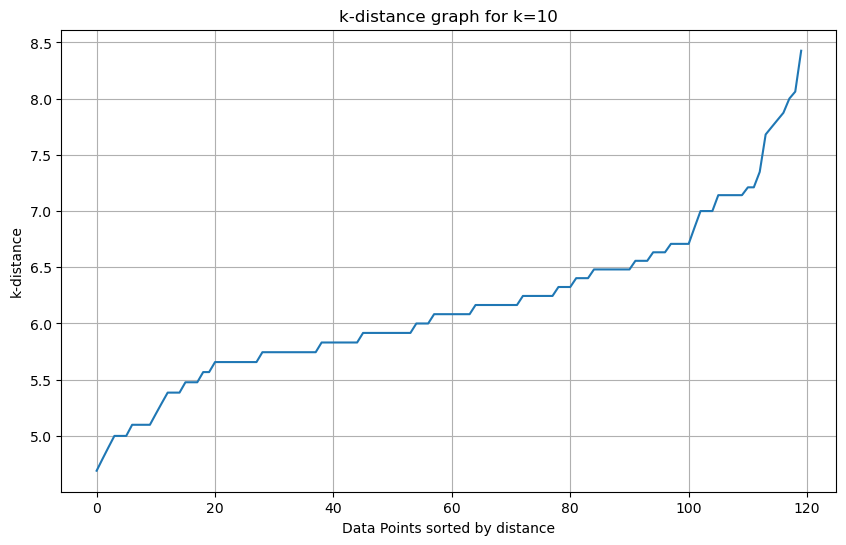

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# k-distance 그래프 생성 함수
def plot_k_distance(data, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, k-1], axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('k-distance')
    plt.title(f'k-distance graph for k={k}')
    plt.grid(True)
    plt.show()

# k-distance 그래프 시각화 (여기서는 k=4로 예시)
ingredient_data = df.drop(columns=['ID','상품명','브랜드','이미지'])
plot_k_distance(ingredient_data, 10)

In [10]:
from sklearn.cluster import DBSCAN

# DBSCAN 클러스터링
dbscan = DBSCAN(eps=6, min_samples=5)
labels = dbscan.fit_predict(ingredient_data)
df['Cluster'] = labels

In [11]:
# 클러스터링 결과 시각화 함수
def plot_clusters(data, labels):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        class_member_mask = (labels == label)
        xy = data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], s=50, color=color, label=f'Cluster {label}')

    plt.title('DBSCAN Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# 2D 데이터로 시각화 (성분1과 성분2만 사용하여 예제 시각화)
plot_clusters(ingredient_data, labels)

InvalidIndexError: (slice(None, None, None), 0)